In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
# Warnings is disabled
import warnings
warnings.simplefilter('ignore')

# Let's display plots in jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 

#set up default size of plots
from pylab import rcParams
rcParams['figure.figsize'] = 4, 3

# a) Download train.csv and test.csv from here https://goo.gl/do3PJY

In [3]:
train = pd.read_csv('train.csv', index_col = 0)
train.head()

x1        x2          y
index                               
0      1.543500  0.718659   2.504393
1      1.721699  1.761218  16.777724
2      1.029734  0.946516   2.898218
3      1.874671  1.921898  21.753827
4      1.914601  1.017112   6.222516

In [4]:
test = pd.read_csv('test.csv', index_col = 0)
test.head()

x1        x2          y
0  2.316800  2.899064  61.172216
1  2.023726  2.141243  29.149661
2  2.483548  2.813282  61.751701
3  2.058335  2.994136  57.970753
4  2.681823  2.869835  69.389524

# b) Perform simple Exploratory Data Analysis on train.csv and test.csv

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9998
Data columns (total 3 columns):
x1    9999 non-null float64
x2    9999 non-null float64
y     9999 non-null float64
dtypes: float64(3)
memory usage: 312.5 KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 3 columns):
x1    99 non-null float64
x2    99 non-null float64
y     99 non-null float64
dtypes: float64(3)
memory usage: 3.1 KB


In [7]:
train.describe()

x1           x2            y
count  9999.000000  9999.000000  9999.000000
mean      1.254987     1.240495     6.802592
std       0.434357     0.437067     5.145863
min       0.500276     0.500349     0.409952
25%       0.877843     0.859612     2.633788
50%       1.257325     1.230718     5.399104
75%       1.637378     1.617182     9.644745
max       1.999694     1.999858    24.888137

In [8]:
test.describe()

x1         x2          y
count  99.000000  99.000000  99.000000
mean    2.529453   2.537210  51.853812
std     0.273708   0.303069  13.202425
min     2.022688   2.005927  26.615201
25%     2.321216   2.313501  40.555725
50%     2.517855   2.574454  52.256939
75%     2.773108   2.805113  60.926427
max     2.985324   2.994136  78.830809

### Here we can see that train and test even don't have intersection. 
### In Machine Learning as usual train and test are from same distribution with similar expectade value and standart deviation. So task _isn't_ very common in ML. It's Extrapolation.

#### Let's take a look on pairplots (for train I use subset to save time & memory)

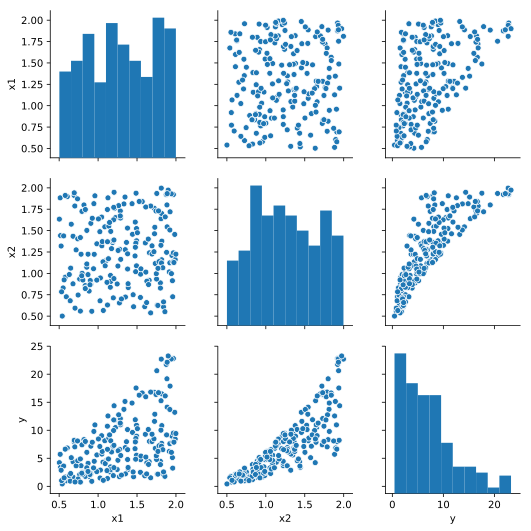

In [10]:
train_pair = sns.pairplot(train.loc[train.index < 200])
#sns_plot.savefig('pairplot_train.png')

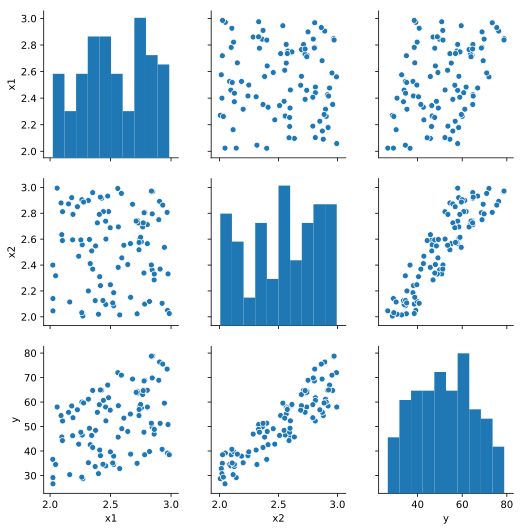

In [11]:
test_pair = sns.pairplot(test)
#sns_plot.savefig('pairplot_test.png')

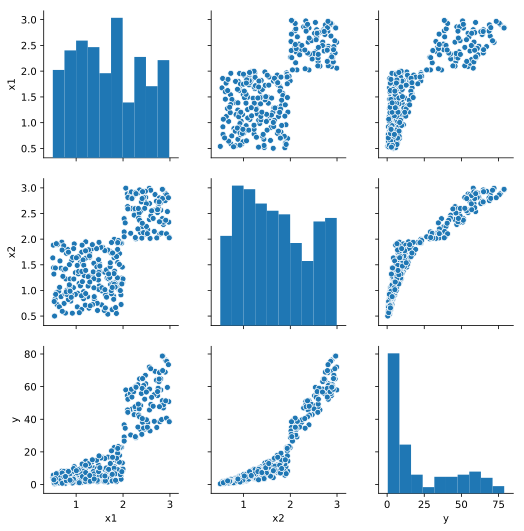

In [12]:
all_pair = sns.pairplot(train.loc[train.index < 200].append(test))

#### Here we can see that dependecies in train and test are not obvious
#### Let's add some variable and see correlations

In [13]:
def add_variables(df):
    df['x1_root'], df['x2_root'] = np.sqrt(df['x1']), np.sqrt(df['x2'])
    df['x1_sq'], df['x2_sq'] = df['x1']**2, df['x2']**2
    df['x1_log'], df['x2_log'] = np.log(df['x1']), np.log(df['x2'])
    df['x1_exp'], df['x2_exp'] = np.exp(df['x1']), np.exp(df['x2'])
    df['x_mult'], df['x2_dev'] = df['x1'] * df['x2'], df['x1'] / df['x2']
    

In [15]:
train_ext, test_ext = train.copy(), test.copy()
add_variables(train_ext), add_variables(test_ext)

(None, None)

/home/sasha/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 1.0, 'Correlations train')

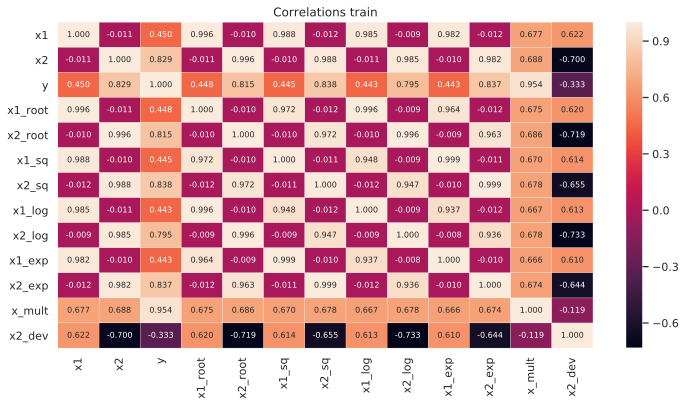

In [19]:
sns.set(rc = {'figure.figsize': (12, 6)})
sns.heatmap(train_ext.corr(), annot = True, fmt = ".3f", annot_kws = {"size": 8}, linewidths = .2);
ax = plt.axes()
ax.set_title('Correlations train')

/home/sasha/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 1.0, 'Correlations test')

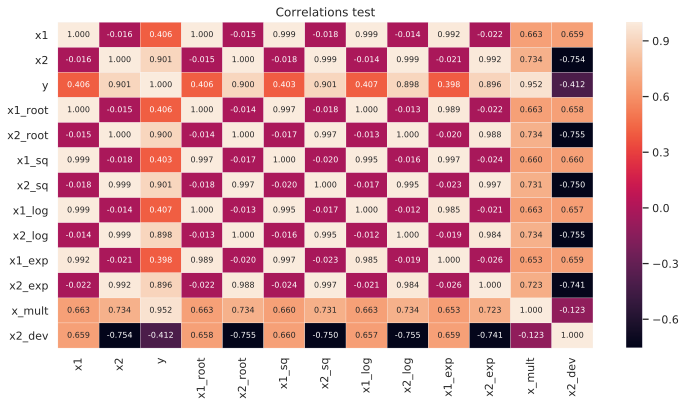

In [20]:
sns.set(rc = {'figure.figsize':(12, 6)})
sns.heatmap(test_ext.corr(), annot = True, fmt = ".3f", annot_kws={"size": 8}, linewidths = .2);
ax = plt.axes()
ax.set_title('Correlations test')

#### Let's note that x1 and x2 have correlation that equal almost 0. It's good.

# c) Use a suitable algorithm to train a machine learning model from the train.csv

#### I will RMSE for test data as well to save time. But of course I will not use this data for decision making.
#### In my case it will be validate

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error

In [23]:
def RMSE(model, test):
    return np.sqrt(mean_squared_error(model, test))

In [32]:
#shuffle train data
train = train.sample(frac = 1).reset_index(drop = True)
stat = pd.DataFrame(columns = ['model', 'train', 'test', 'validate'])

In [30]:
X_train = train.loc[train.index < 7000, ['x1', 'x2']].copy()
X_test = train.loc[train.index >= 7000, ['x1', 'x2']].copy()
y_train, y_test = train['y'][:7000].copy(), train['y'][7000:].copy()

X_val = test[['x1', 'x2']]
y_val = test[['y']]

### 1. Base Linear Regression

In [34]:
reg = LinearRegression().fit(X_train, y_train)

rmse_train = round(RMSE(reg.predict(X_train), y_train), 5)
rmse_test = round(RMSE(reg.predict(X_test), y_test), 5)
rmse_val = round(RMSE(reg.predict(X_val), y_val), 5)

stat = stat.append(pd.DataFrame({
    'model': ['lin regr base'],
    'train': rmse_train,
    'test': rmse_test,
    'validate': rmse_val
}), ignore_index = True)

print('RMSE for train: {}'.format(rmse_train))
print('RMSE for test:  {}'.format(rmse_test))
print('RMSE for val:   {}'.format(rmse_val))

RMSE for train: 1.64323
RMSE for test:  1.65328
RMSE for val:   27.26049


### 2. SVM Regressor base with different kernels

In [37]:
%%time
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    print('{}: {}'.format(kernel, str(datetime.now().time())[:8]))
    reg = svm.SVR(kernel = kernel)
    reg.fit(X_train, y_train)

    rmse_train = round(RMSE(reg.predict(X_train), y_train), 5)
    rmse_test = round(RMSE(reg.predict(X_test), y_test), 5)
    rmse_val = round(RMSE(reg.predict(X_val), y_val), 5)

    stat = stat.append(pd.DataFrame({
        'model': ['svm base | {}'.format(kernel)],
        'train': rmse_train,
        'test': rmse_test,
        'validate': rmse_val
    }), ignore_index = True)

linear: 16:23:55
poly: 16:23:57
rbf: 16:23:57
sigmoid: 16:23:58
CPU times: user 6.44 s, sys: 156 ms, total: 6.59 s
Wall time: 6.59 s


In [38]:
stat

model      train       test   validate
0       lin regr base    1.64323    1.65328   27.26049
1   svm base | linear    1.72916    1.74864   28.87304
2     svm base | poly    0.06875    0.06888    0.26307
3      svm base | rbf    0.10012    0.10450   26.78395
4  svm base | sigmoid  131.50358  133.46935  386.01565

#### I guess that record was calculated using SVM polinomial without tuning

### 3. SVM Regressor with Grid Search

In [40]:
%%time
param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 10],
    'gamma': ['auto', 'scale'],
    'epsilon': [0.05, 0.1, 0.5]
}

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    print('{}: {}'.format(kernel, str(datetime.now().time())[:8]))
    optimizer = GridSearchCV(svm.SVR(kernel = kernel), param_grid, cv = 4)
    optimizer.fit(X_train, y_train)

    rmse_train = round(RMSE(optimizer.predict(X_train), y_train), 5)
    rmse_test = round(RMSE(optimizer.predict(X_test), y_test), 5)
    rmse_val = round(RMSE(optimizer.predict(X_val), y_val), 5)

    stat = stat.append(pd.DataFrame({
        'model': ['svm grid | {}'.format(kernel)],
        'train': rmse_train,
        'test': rmse_test,
        'validate': rmse_val
    }), ignore_index = True)

linear: 16:30:32
poly: 16:33:13
rbf: 16:33:35
sigmoid: 16:35:35
CPU times: user 11min 22s, sys: 14.4 s, total: 11min 36s
Wall time: 11min 36s


### 4. NuSVM Regressor with Grid Search

#### I'll run here only for polinomial to save time. I tested for anothere kernels. As expected it's not good models

In [47]:
%%time
param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 10],
    'gamma': ['auto', 'scale'],
    'nu': [0.05, 0.1, 0.5, 0.7]
}

for kernel in ['poly']:#['linear', 'poly', 'rbf', 'sigmoid']:
    print('{}: {}'.format(kernel, str(datetime.now().time())[:8]))
    optimizer = GridSearchCV(svm.NuSVR(kernel = kernel), param_grid, cv = 4)
    optimizer.fit(X_train, y_train)
    rmse_train = round(RMSE(optimizer.predict(X_train), y_train), 5)
    rmse_test = round(RMSE(optimizer.predict(X_test), y_test), 5)
    rmse_val = round(RMSE(optimizer.predict(X_val), y_val), 5)

    stat = stat.append(pd.DataFrame({
        'model': ['nu_svm grid | {}'.format(kernel)],
        'train': rmse_train,
        'test': rmse_test,
        'validate': rmse_val
    }), ignore_index = True)

poly: 16:46:13
CPU times: user 30.1 s, sys: 1.32 s, total: 31.4 s
Wall time: 31.4 s


### 5. Random Forest with Grid Search

In [48]:
%%time
param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [2, 4, 8],
    'bootstrap': [True, False] 
}
optimizer = GridSearchCV(RandomForestRegressor(random_state = 0), param_grid, cv = 5)
optimizer.fit(X_train, y_train)

rmse_train = round(RMSE(optimizer.predict(X_train), y_train), 5)
rmse_test = round(RMSE(optimizer.predict(X_test), y_test), 5)
rmse_val = round(RMSE(optimizer.predict(X_val), y_val), 5)

stat = stat.append(pd.DataFrame({
    'model': ['random forest grid'],
    'train': rmse_train,
    'test': rmse_test,
    'validate': rmse_val
}), ignore_index = True)

CPU times: user 41.6 s, sys: 0 ns, total: 41.6 s
Wall time: 41.6 s


### 6. Gradient Boosting

In [49]:
%%time
param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [2, 4, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]
}
for loss in ['ls', 'lad', 'huber', 'quantile']:
    print('{}: {}'.format(loss, str(datetime.now().time())[:8]))
    optimizer = GridSearchCV(GradientBoostingRegressor(loss = loss, random_state = 0), param_grid, cv = 5)
    optimizer.fit(X_train, y_train)

    rmse_train = round(RMSE(optimizer.predict(X_train), y_train), 5)
    rmse_test = round(RMSE(optimizer.predict(X_test), y_test), 5)
    rmse_val = round(RMSE(optimizer.predict(X_val), y_val), 5)

    stat = stat.append(pd.DataFrame({
        'model': ['gradient boosting grid | {}'.format(loss)],
        'train': rmse_train,
        'test': rmse_test,
        'validate': rmse_val
    }), ignore_index = True)

ls: 16:48:59
lad: 16:49:56
huber: 16:51:32
quantile: 16:55:16
CPU times: user 7min 24s, sys: 48 ms, total: 7min 24s
Wall time: 7min 24s


### 7. Feature engineering

In [55]:
stat_eng = pd.DataFrame(columns = ['model', 'columns', 'train', 'test', 'validate'])

#### Here I'll play with feautures (tune hyperparameters). For this case I have to do additional validation.

### 7.1 Linear regression

In [56]:
%%time
columns = train_ext.drop('y', axis = 1).columns
df = []
train_ext = train_ext.sample(frac = 1).reset_index(drop = True)
y_train, y_test = train_ext['y'][:7000], train_ext['y'][7000:]

for i in range(1, 2**12):
    cols = []
    binary = bin(i)[2:]
    binary = '0' * (12 - len(binary)) + binary
    for j in range(12):
        if binary[j] == '1':
            cols.append(columns[j])
    
    X_train = train_ext.loc[train_ext.index < 7000, cols].copy()
    X_test = train_ext.loc[train_ext.index >= 7000, cols].copy()
    X_val = test_ext[cols].copy()
    reg = LinearRegression().fit(X_train, y_train)
    
    rmse_train = round(RMSE(reg.predict(X_train), y_train), 5)
    rmse_test = round(RMSE(reg.predict(X_test), y_test), 5)
    rmse_val = round(RMSE(reg.predict(X_val), y_val), 5)
    
    stat_eng = stat_eng.append(pd.DataFrame({
        'model': ['lin regr base'],
        'columns': ' | '.join(cols),
        'train': rmse_train,
        'test': rmse_test,
        'validate': rmse_val
    }), ignore_index = True)

    

CPU times: user 2min 46s, sys: 91.9 ms, total: 2min 46s
Wall time: 41.7 s


In [59]:
stat_eng.loc[stat_eng['test'] == stat_eng['test'].min()]

model                                            columns  \
3350  lin regr base  x1 | x2 | x2_root | x2_log | x2_exp | x_mult |...   
3410  lin regr base  x1 | x2 | x2_root | x2_sq | x2_log | x_mult | ...   
3414  lin regr base  x1 | x2 | x2_root | x2_sq | x2_log | x2_exp | ...   

        train     test  validate  
3350  0.07808  0.07937   4.21485  
3410  0.07809  0.07937   4.50332  
3414  0.07808  0.07937   4.12127

### 7.2 SGD Regressor with Grid Search

#### I will not run now because it takes more than 2 hours. But this model is not the worst one.

In [64]:
%%time
param_grid = {
    'l1_ratio': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.35, 0.4, 0.5, 0.7, 0.9, 1],
    'penalty' : ['none', 'l2', 'l1', 'elasticnet']
}
optimizer = GridSearchCV(SGDRegressor(), param_grid, cv = 5)

for i in range(1, 2**4):
    cols = []
    binary = bin(i)[2:]
    binary = '0' * (12 - len(binary)) + binary
    for j in range(12):
        if binary[j] == '1':
            cols.append(columns[j])
    
    X_train = train_ext.loc[train_ext.index < 7000, cols].copy()
    X_test = train_ext.loc[train_ext.index >= 7000, cols].copy()
    X_val = test_ext[cols].copy()
    optimizer.fit(X_train[cols], y_train)

    rmse_train = round(RMSE(optimizer.predict(X_train), y_train), 5)
    rmse_test = round(RMSE(optimizer.predict(X_test), y_test), 5)
    rmse_val = round(RMSE(optimizer.predict(X_val), y_val), 5)
    
    stat_eng = stat_eng.append(pd.DataFrame({
        'model': ['SGD'],
        'columns': ' | '.join(cols),
        'train': rmse_train,
        'test': rmse_test,
        'validate': rmse_val
    }), ignore_index = True)

CPU times: user 1min 11s, sys: 7.61 ms, total: 1min 11s
Wall time: 27.3 s


## c) Interpret the model by showing its metrics.

#### There are plenty metrics for regression. We can choose them for example here $https://scikit-learn.org/stable/modules/model_evaluation.html$

#### We'll use RMSE to choose right model. We have to choose model with one of the minimum values of test RMSE. It's nice if model is not overfitted.

In [75]:
stat.sort_values(by = ['test'])

model      train       test   validate
9                  nu_svm grid | poly    0.00008    0.00008    0.00047
7                      svm grid | rbf    0.03181    0.03158   30.82169
6                     svm grid | poly    0.03268    0.03272    0.12527
2                     svm base | poly    0.06875    0.06888    0.26307
13     gradient boosting grid | huber    0.03431    0.07677   30.43316
11        gradient boosting grid | ls    0.02324    0.07886   30.00299
3                      svm base | rbf    0.10012    0.10450   26.78395
12       gradient boosting grid | lad    0.09455    0.13096   31.09949
10                 random forest grid    0.11103    0.14957   30.80323
14  gradient boosting grid | quantile    0.36135    0.36769   30.19812
0                       lin regr base    1.64323    1.65328   27.26049
5                   svm grid | linear    1.68505    1.70177   28.48060
1                   svm base | linear    1.72916    1.74864   28.87304
8                  svm grid | sigmoid    5.71490    5.77981   48.66144
4                  svm base | sigmoid  131.50358  133.46935  386.01565

#### Obviously that there is some polinomial rule.
#### But also there is overfitting for rbf kernel. It's possible because test is from extrapolated data. And also we can analyse what's wrong with this model later.

## e) Test.csv contains extrapolated data. Use the trained model to infer/predict the y values in test.csv. You may use y_hat  as the predicted values column and retain original y column to be used to complete the next step.

#### Actually I've already done it above. But I'll repeat for the best model. And I'll train model using full train dataset.

In [79]:
%%time
param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 10],
    'gamma': ['auto', 'scale'],
    'nu': [0.05, 0.1, 0.5, 0.7]
}

optimizer = GridSearchCV(svm.NuSVR(kernel = 'poly'), param_grid, cv = 4)

optimizer.fit(train[['x1', 'x2']], train['y'])
test['y_hat'] = optimizer.predict(test[['x1', 'x2']])

CPU times: user 49.8 s, sys: 2.49 s, total: 52.3 s
Wall time: 52.3 s


## f) Write down your train and test RMSE. You may attempt to improve your RMSE to as low as possible by experimenting different ML algorithm or techniques, you may retain all the codes used to test different models and only pick the best result. For reference the base RMSE of test data is 25.36 and average is 15.99 and lowest recorded is 0.24

In [80]:
print('train RMSE = {}'.format(RMSE(train['y'], optimizer.predict(train[['x1', 'x2']]))))
print('train RMSE = {}'.format(RMSE(test['y'], test['y_hat'])))

train RMSE = 0.00018822336485462845
train RMSE = 0.0011004666084813493


#### Based on the result I can guess that there is a polynomial rule with some noise